In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

import numpy as np
import time
import matplotlib.pyplot as plt
from metrics import calc_rmse, calc_mape, calc_mae
from data_processing import create_sequences
from models import RNN, GRU, LSTM

In [2]:
mapping = {
    'NE': 1,
    'SE': 2,
    'NW': 3,
    'cv': 4
}

In [3]:
pollution_data = pd.read_csv("datasets/pollution_data.csv")
pollution_data.wnd_dir = pollution_data.wnd_dir.map(mapping)

pollution_data.set_index('date', inplace=True, drop=True)
pollution_data.index = pd.to_datetime(pollution_data.index)
pollution_data.sample(5)
pollution_data

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,3,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,3,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,3,242.70,0,0


In [4]:
# multivar_pollution_data = pollution_data.drop(columns=['date', 'wnd_dir', 'snow', 'rain', 'wnd_spd', 'press'])
multivar_pollution_data = pollution_data


In [5]:
scale = MinMaxScaler()
columns = multivar_pollution_data.columns

data_scaled = multivar_pollution_data.copy()
scale.fit(data_scaled[columns])

data_scaled[columns] = scale.fit_transform(data_scaled[columns])
data_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [6]:
num_features = data_scaled.shape[1]

window_size = 100


In [7]:
data_scaled = data_scaled.reset_index(drop=True)


In [8]:
sequences_normalized, labels_normalized = create_sequences(data_scaled, window_size)


In [9]:
labels_normalized

array([0.02716298, 0.02816901, 0.02112676, ..., 0.01006036, 0.00804829,
       0.01207243])

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
total_samples = sequences_normalized.shape[0]
split_index = int(total_samples * 0.8)  # 80% for training, 20% for testing

# Split the data
X_train = torch.tensor(sequences_normalized[:split_index, :, np.newaxis], dtype=torch.float32)
y_train = torch.tensor(labels_normalized[:split_index], dtype=torch.float32)
X_test = torch.tensor(sequences_normalized[split_index:, :, np.newaxis], dtype=torch.float32)
y_test = torch.tensor(labels_normalized[split_index:], dtype=torch.float32)


In [12]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)


In [13]:
batch_size = 64  # You can adjust the batch size depending on your memory capacity and model needs

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
train_loader

In [15]:
input_size = num_features
hidden_size = 20
num_layers = 2
output_size = 1

In [16]:
rnn_model = RNN(input_size, hidden_size, output_size, num_layers).to(device)
gru_model = GRU(input_size, hidden_size, output_size, num_layers).to(device)
lstm_model = LSTM(input_size, hidden_size, output_size, num_layers).to(device)

In [17]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """Train the model."""
    train_history = {'loss': [], 'rmse': [], 'mae': [], 'mape': []}
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        total_loss, total_rmse, total_mae, total_mape = 0, 0, 0, 0

        for inputs, targets in train_loader:

            inputs = inputs.squeeze(2)  
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Remove the extra dimension

            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            total_rmse += calc_rmse(outputs, targets).item()
            total_mae += calc_mae(outputs, targets).item()
            total_mape += calc_mape(outputs, targets).item()
        
        # Store metrics for training
        num_batches = len(train_loader)
        train_history['loss'].append(total_loss / num_batches)
        train_history['rmse'].append(total_rmse / num_batches)
        train_history['mae'].append(total_mae / num_batches)
        train_history['mape'].append(total_mape / num_batches)

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Total Training time: {training_time:.2f} seconds")
    return train_history

def evaluate_model(model, data_loader, device):

    model.eval()
    criterion_mse = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    total_mae = 0.0
    total_absolute_percentage_error = 0.0
    total_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.squeeze(2)  

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Remove the extra dimension

            mse = criterion_mse(outputs, targets)
            mae = torch.nn.functional.l1_loss(outputs, targets, reduction='sum')
            
            percentage_error = torch.abs((outputs - targets) / targets)
            total_absolute_percentage_error += percentage_error.sum().item()
            
            total_mse += mse.item()
            total_mae += mae.item()
            total_samples += targets.size(0)

    rmse = np.sqrt(total_mse / total_samples)
    mae = total_mae / total_samples
    mape = (total_absolute_percentage_error / total_samples) * 100
    
    print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%')
    end_time = time.time()
    evaluation_time = end_time - start_time
    print(f"Total Evaluation time: {evaluation_time:.2f} seconds")
    return rmse, mae, mape

In [18]:
for inputs, targets in train_loader:
    inputs = inputs.squeeze(2)  

    print(inputs.shape)  # Check the shape of the inputs
    print(targets.shape)
    break

torch.Size([64, 100, 8])
torch.Size([64])


In [19]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """Train the model and evaluate at each epoch, tracking loss, RMSE, MAE, and MAPE."""
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_rmse': [],
        'train_mae': [],
        'train_mape': [],
        'val_rmse': [],
        'val_mae': [],
        'val_mape': []
    }

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_rmse, total_mae, total_mape, train_batches = 0, 0, 0, 0, 0

        # Training loop
        for inputs, targets in train_loader:
            inputs = inputs.squeeze(2).to(device)  # Ensure correct input dimensions
            targets = targets.unsqueeze(1)

            targets = targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs) # Match output dimensions with targets

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Calculate metrics
            total_train_loss += loss.item()
            total_rmse += np.sqrt(criterion(outputs, targets).item())
            total_mae += torch.nn.functional.l1_loss(outputs, targets, reduction='sum').item()
            total_mape += (torch.abs((outputs - targets) / targets).mean() * 100).item()
            train_batches += 1

        # Average training metrics
        history['train_loss'].append(total_train_loss / train_batches)
        history['train_rmse'].append(total_rmse / train_batches)
        history['train_mae'].append(total_mae / train_batches)
        history['train_mape'].append(total_mape / train_batches)

        # Validation loop
        model.eval()
        total_val_loss, val_rmse, val_mae, val_mape, val_batches = 0, 0, 0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.squeeze(2).to(device)
                targets = targets.to(device)
                targets = targets.unsqueeze(1)

                outputs = model(inputs)
                val_loss = criterion(outputs, targets)
                total_val_loss += val_loss.item()
                val_rmse += np.sqrt(val_loss.item())
                val_mae += torch.nn.functional.l1_loss(outputs, targets, reduction='sum').item()
                val_mape += (torch.abs((outputs - targets) / targets).mean() * 100).item()
                print(val_mape)
                val_batches += 1

        # Average validation metrics
        history['val_loss'].append(total_val_loss / val_batches)
        history['val_rmse'].append(val_rmse / val_batches)
        history['val_mae'].append(val_mae / val_batches)
        history['val_mape'].append(val_mape / val_batches)

        # Output current epoch metrics
        print(f'Epoch [{epoch + 1}/{num_epochs}]: '
              f'Train Loss: {history["train_loss"][-1]:.4f}, Train RMSE: {history["train_rmse"][-1]:.4f}, Train MAE: {history["train_mae"][-1]:.4f}, Train MAPE: {history["train_mape"][-1]:.2f}%, '
              f'Val Loss: {history["val_loss"][-1]:.4f}, Val RMSE: {history["val_rmse"][-1]:.4f}, Val MAE: {history["val_mae"][-1]:.4f}, Val MAPE: {history["val_mape"][-1]:.2f}%')

    return history

In [20]:

criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
train_and_evaluate(rnn_model, train_loader, test_loader, criterion, optimizer, 30, device)


Epoch [1/30]: Train Loss: 0.0020, Train RMSE: 0.0390, Train MAE: 1.6329, Train MAPE: inf%, Val Loss: 0.0008, Val RMSE: 0.0254, Val MAE: 1.0949, Val MAPE: inf%
Epoch [2/30]: Train Loss: 0.0009, Train RMSE: 0.0273, Train MAE: 1.0267, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0212, Val MAE: 0.8412, Val MAPE: inf%
Epoch [3/30]: Train Loss: 0.0008, Train RMSE: 0.0264, Train MAE: 0.9886, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0214, Val MAE: 0.8622, Val MAPE: inf%
Epoch [4/30]: Train Loss: 0.0008, Train RMSE: 0.0259, Train MAE: 0.9485, Train MAPE: inf%, Val Loss: 0.0008, Val RMSE: 0.0246, Val MAE: 1.1180, Val MAPE: inf%
Epoch [5/30]: Train Loss: 0.0008, Train RMSE: 0.0262, Train MAE: 0.9705, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0210, Val MAE: 0.8252, Val MAPE: inf%
Epoch [6/30]: Train Loss: 0.0008, Train RMSE: 0.0258, Train MAE: 0.9458, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0223, Val MAE: 0.9504, Val MAPE: inf%
Epoch [7/30]: Train Loss: 0.0008, Train RMSE: 

{'train_loss': [0.0019673382142936244,
  0.0008544893372666441,
  0.0008201641824181145,
  0.0008005637005018326,
  0.0008123217791332089,
  0.0007966650399622904,
  0.0008046876757937336,
  0.0008019714365265089,
  0.0008044118017819752,
  0.0008092568740350836,
  0.0007986764382207903,
  0.0008039392458664005,
  0.0007910314165154715,
  0.0007932852628901329,
  0.0007936034230915472,
  0.0007922941015099415,
  0.0007920885064915398,
  0.0007931684659197211,
  0.000789610501204258,
  0.0007868771738916724,
  0.0007810098525655789,
  0.0007761042160393842,
  0.0007798454373862324,
  0.0007772127345456126,
  0.000772217595134649,
  0.0007684040237403299,
  0.000754975528312401,
  0.0007541705812470157,
  0.0007606725130992954,
  0.0007536717455568545],
 'val_loss': [0.0007783466325282548,
  0.0005984798480425604,
  0.0006205862740978401,
  0.0007501619462332566,
  0.0005895590564609083,
  0.0006495427501880323,
  0.0006296513673303867,
  0.0006219217182820268,
  0.0006362048681335945,
 

In [21]:

criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 30
train_and_evaluate(rnn_model, train_loader, test_loader, criterion, optimizer, 30, device)


Epoch [1/30]: Train Loss: 0.0007, Train RMSE: 0.0253, Train MAE: 0.9270, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0213, Val MAE: 0.8900, Val MAPE: inf%
Epoch [2/30]: Train Loss: 0.0007, Train RMSE: 0.0254, Train MAE: 0.9274, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0209, Val MAE: 0.8038, Val MAPE: inf%
Epoch [3/30]: Train Loss: 0.0007, Train RMSE: 0.0250, Train MAE: 0.9107, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0212, Val MAE: 0.8647, Val MAPE: inf%
Epoch [4/30]: Train Loss: 0.0007, Train RMSE: 0.0251, Train MAE: 0.9104, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0205, Val MAE: 0.8120, Val MAPE: inf%
Epoch [5/30]: Train Loss: 0.0007, Train RMSE: 0.0252, Train MAE: 0.9283, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0207, Val MAE: 0.7904, Val MAPE: inf%
Epoch [6/30]: Train Loss: 0.0007, Train RMSE: 0.0250, Train MAE: 0.9054, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0210, Val MAE: 0.8324, Val MAPE: inf%
Epoch [7/30]: Train Loss: 0.0007, Train RMSE: 

{'train_loss': [0.0007483404694341925,
  0.0007459751535000593,
  0.0007388522809433497,
  0.0007351061466358129,
  0.000739534392871407,
  0.0007276761000948299,
  0.0007279130954327746,
  0.0007294139255394127,
  0.0007280604660169858,
  0.0007229622428603828,
  0.0007254760057149945,
  0.0007203325611782657,
  0.0007184726134140745,
  0.0007205453339887109,
  0.0007165054724779673,
  0.0007158190199822891,
  0.000711530686860097,
  0.0007075076807103881,
  0.0007128792842471261,
  0.00070512163742193,
  0.0007115144667420383,
  0.0007039869299376174,
  0.0007082216738894756,
  0.0007014500103968364,
  0.0006994291818587933,
  0.000698285962155849,
  0.0007020440854724254,
  0.0006999753796435055,
  0.0007012221971045758,
  0.0006977993855497611],
 'val_loss': [0.0005937535336995701,
  0.0005833823331298194,
  0.0005838994479977805,
  0.0005589113080552031,
  0.0005696825309493834,
  0.0005805946305631252,
  0.0005810489879864146,
  0.0005913256931453893,
  0.0005654589092251879,
  0

In [22]:
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 30
gru_training_data = train_and_evaluate(gru_model, train_loader, test_loader, criterion, optimizer, num_epochs, device)




Epoch [1/30]: Train Loss: 0.0030, Train RMSE: 0.0463, Train MAE: 2.0486, Train MAPE: inf%, Val Loss: 0.0008, Val RMSE: 0.0245, Val MAE: 1.0584, Val MAPE: inf%
Epoch [2/30]: Train Loss: 0.0008, Train RMSE: 0.0270, Train MAE: 1.0118, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0212, Val MAE: 0.8255, Val MAPE: inf%
Epoch [3/30]: Train Loss: 0.0008, Train RMSE: 0.0261, Train MAE: 0.9630, Train MAPE: inf%, Val Loss: 0.0008, Val RMSE: 0.0264, Val MAE: 1.2696, Val MAPE: inf%
Epoch [4/30]: Train Loss: 0.0008, Train RMSE: 0.0257, Train MAE: 0.9397, Train MAPE: inf%, Val Loss: 0.0007, Val RMSE: 0.0231, Val MAE: 1.0158, Val MAPE: inf%
Epoch [5/30]: Train Loss: 0.0008, Train RMSE: 0.0257, Train MAE: 0.9465, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0208, Val MAE: 0.8191, Val MAPE: inf%
Epoch [6/30]: Train Loss: 0.0008, Train RMSE: 0.0258, Train MAE: 0.9403, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0212, Val MAE: 0.8568, Val MAPE: inf%
Epoch [7/30]: Train Loss: 0.0008, Train RMSE: 

In [23]:
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 30
lstm_training_data = train_and_evaluate(lstm_model, train_loader, test_loader, criterion, optimizer, num_epochs, device)



Epoch [1/30]: Train Loss: 0.0041, Train RMSE: 0.0579, Train MAE: 2.6648, Train MAPE: inf%, Val Loss: 0.0014, Val RMSE: 0.0345, Val MAE: 1.7114, Val MAPE: inf%
Epoch [2/30]: Train Loss: 0.0011, Train RMSE: 0.0318, Train MAE: 1.2807, Train MAPE: inf%, Val Loss: 0.0007, Val RMSE: 0.0235, Val MAE: 0.9971, Val MAPE: inf%
Epoch [3/30]: Train Loss: 0.0009, Train RMSE: 0.0275, Train MAE: 1.0635, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0213, Val MAE: 0.8733, Val MAPE: inf%
Epoch [4/30]: Train Loss: 0.0008, Train RMSE: 0.0261, Train MAE: 0.9829, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0210, Val MAE: 0.8452, Val MAPE: inf%
Epoch [5/30]: Train Loss: 0.0008, Train RMSE: 0.0257, Train MAE: 0.9509, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0206, Val MAE: 0.8132, Val MAPE: inf%
Epoch [6/30]: Train Loss: 0.0008, Train RMSE: 0.0259, Train MAE: 0.9695, Train MAPE: inf%, Val Loss: 0.0006, Val RMSE: 0.0213, Val MAE: 0.8869, Val MAPE: inf%
Epoch [7/30]: Train Loss: 0.0008, Train RMSE: 

KeyboardInterrupt: 

In [ ]:

def plot_metrics(train_history, title='Training Performance Metrics'):
    """Plots separate graphs for each training metric over epochs.
    
    Args:
        train_history (dict): A dictionary containing lists of metrics per epoch for training.
        title (str): Overall title for the plots.
    """
    num_metrics = len(train_history.keys())
    plt.figure(figsize=(12, 3 * num_metrics))  # Adjust overall figure size

    # Create a subplot for each metric in the history dictionary
    for i, key in enumerate(train_history.keys(), 1):
        plt.subplot(num_metrics, 1, i)  # Create subplots in a vertical layout
        metric_data = train_history[key]
        
        # Ensure data is on CPU and in NumPy format for plotting
        if isinstance(metric_data[0], torch.Tensor):  # Check if the data is in tensor format
            metric_data = [x.cpu().detach().numpy() if x.is_cuda else x.numpy() for x in metric_data]
        
        plt.plot(metric_data, label=f'Train {key}')  # Adding markers for clarity
        plt.title(f'{key.upper()} Over Time')
        plt.xlabel('Epochs')
        plt.ylabel(key.capitalize())
        plt.grid(True)
        plt.legend()

    plt.tight_layout(pad=2.0)  # Adjust layout to prevent overlap
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.88)  # Adjust top margin to fit the main title
    plt.show()



In [ ]:
plot_metrics(rnn_training_data, title='RNN Training Performance Metrics')

NameError: name 'rnn_training_data' is not defined

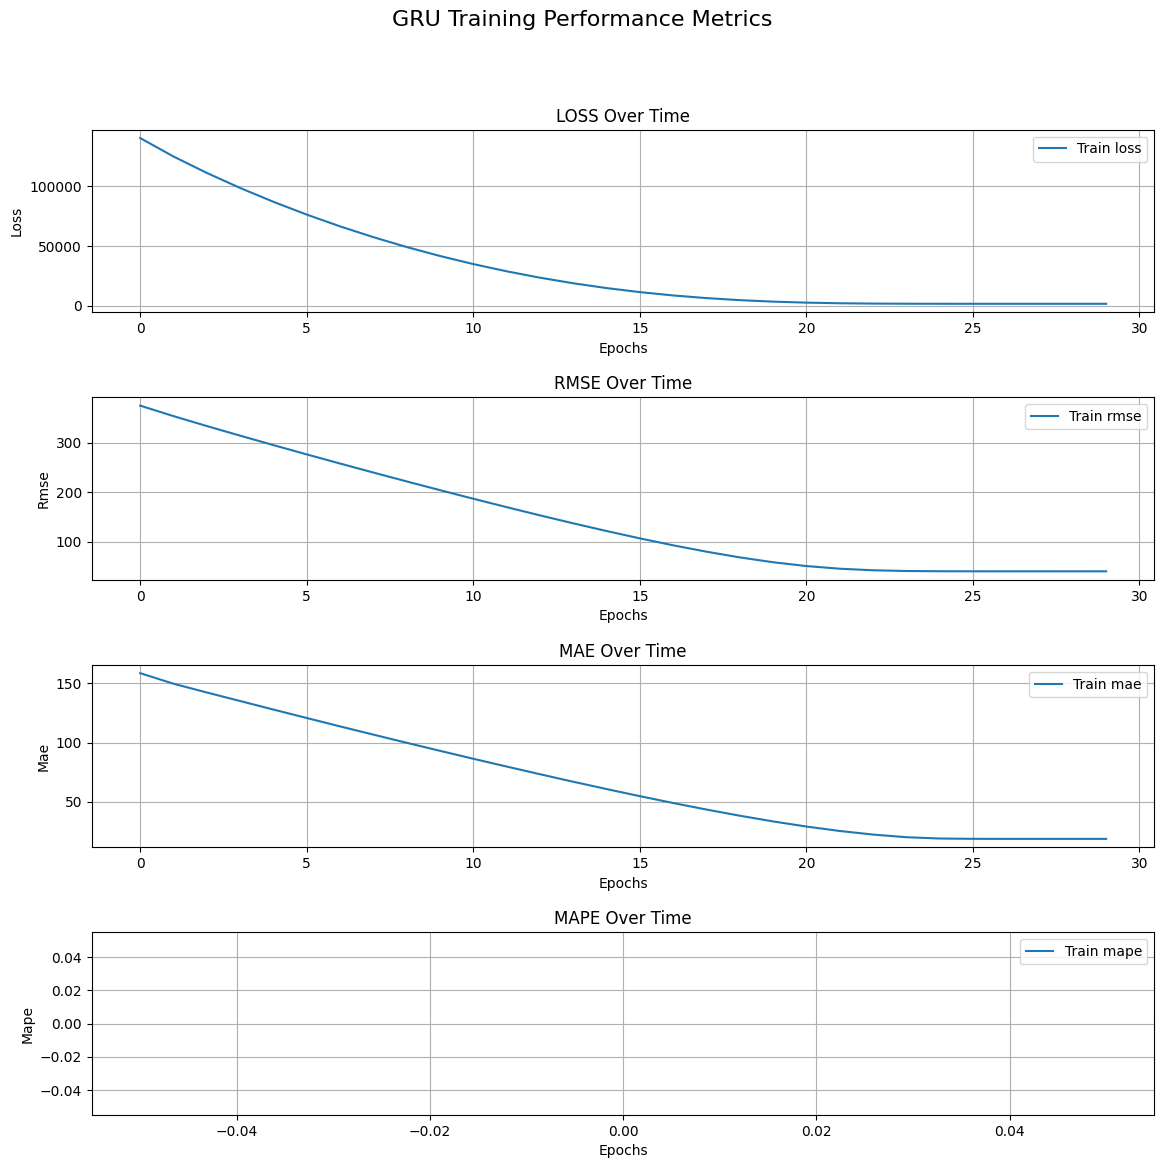

In [ ]:
plot_metrics(gru_training_data, title='GRU Training Performance Metrics')

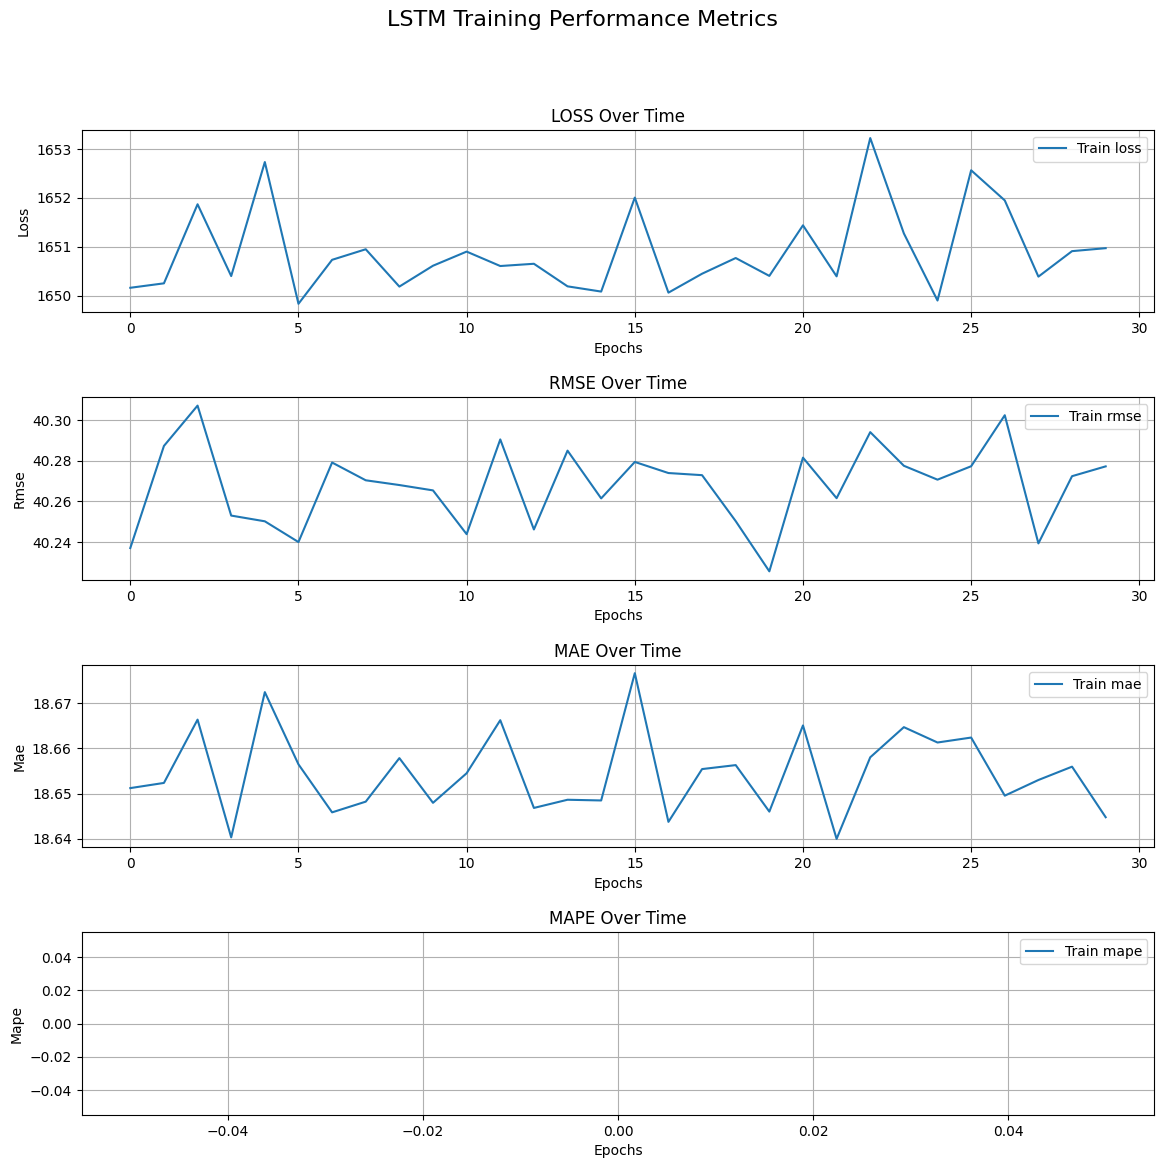

In [ ]:
plot_metrics(lstm_training_data, title='LSTM Training Performance Metrics')